First download the list 

In [10]:
import requests
import os

dir_path = os.getcwd()

lista_finale_post_script_3_csv = os.path.join(dir_path, "lista_finale_post_script_3.csv")
lista_finale_csv = os.path.join(dir_path, "lista_finale.csv")

# Construct the URL for exporting the sheet in CSV format
lista_finale_post_script_3_URL = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=2002066435"
lista_finale_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=92667368"


try:
  # Download the lista finale post script 3
  response = requests.get(lista_finale_post_script_3_URL)
  response.raise_for_status()
  with open(lista_finale_post_script_3_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved to {lista_finale_post_script_3_csv}")

  # Download the lista finale
  response = requests.get(lista_finale_url)
  response.raise_for_status()
  with open(lista_finale_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved to {lista_finale_csv}")

except requests.exceptions.RequestException as e:
  print(f"Error downloading the Google Sheet: {e}")

Lista finale downloaded successfully and saved to /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/lista_finale_post_script_3.csv
Lista finale downloaded successfully and saved to /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/lista_finale.csv


In [11]:
import pandas as pd
import pywaffle as pw
import matplotlib.pyplot as plt

KEY_URL_PROGETTO = "URL progetto"
KEY_URL_PROGETTO_RISOLVE = "URL progetto risolve?"
KEY_URL_PROGETTO_FIRST_SEEN = "URL progetto First_Seen"
KEY_URL_PROGETTO_LAST_SEEN = "URL progetto Last_Seen"
KEY_URL_PARZIALMENTE_INACCESSIBILE = "Parzialmente Inacessibile"

data = pd.read_csv(lista_finale_csv)
data_with_dates = pd.read_csv(lista_finale_post_script_3_csv)

# Add columns for first seen and last seen dates
data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data_with_dates[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data_with_dates[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')

projects_total = len(data)

# Filter out projects with no URL
projects_data = data[data[KEY_URL_PROGETTO].notna()]
projects_url_total = len(projects_data)

# Filter out projects with no dates
projects_dates = projects_data[
  (pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce').notna()) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce').notna())
]
projects_dates_total = len(projects_dates)

# Filter out projects with no resolving URL
projects_resolving_url = projects_data[data[KEY_URL_PROGETTO_RISOLVE] == True]
projects_url_resolving_total = len(projects_resolving_url)


projects_parzialmente_inaccessibile = projects_data[data[KEY_URL_PARZIALMENTE_INACCESSIBILE] == True]
projects_parzialmente_inaccessibile_total = len(projects_parzialmente_inaccessibile)

dataset1 = os.path.join(dir_path, "dataset_1.csv")
data.set_index("Titolo", inplace=True)
data.to_csv(dataset1, escapechar='\\', quoting=1)
print(f"Data saved to {dataset1}")

print("Projects Overview:")
print(f"Projects: {projects_url_total}")
print(f"Projects with valid first seen and last seen dates: {projects_dates_total}")
print(f"Projects with resolving URL: {projects_url_resolving_total}")
print(f"Projects partially inaccessible: {projects_parzialmente_inaccessibile_total}")

# Create and store Waffle chart
data = {
  'Projects': projects_url_total ,
  'Projects with dates': projects_dates_total ,
  'Projects with resolving URL': projects_url_resolving_total,
}


Data saved to /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/dataset_1.csv
Projects Overview:
Projects: 243
Projects with valid first seen and last seen dates: 230
Projects with resolving URL: 201
Projects partially inaccessible: 38


/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp/T/ipykernel_90582/531641461.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data_with_dates[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp/T/ipykernel_90582/531641461.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data_with_dates[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')
/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp/T/ipykernel_90582/531641461.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  projects_dates = projects_data[
/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp

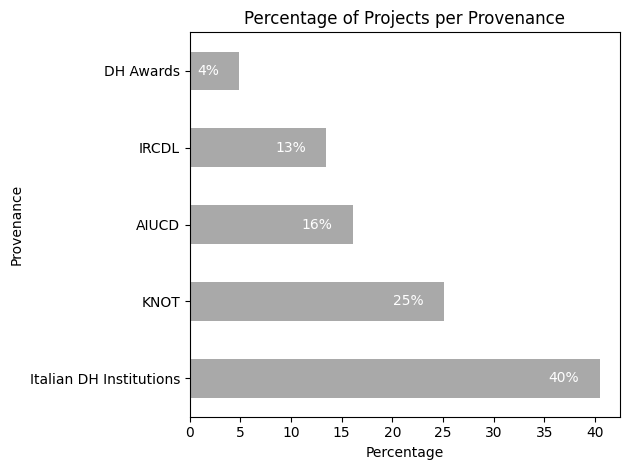

In [12]:
# Calculate the percentage of projects per provenance
data = pd.read_csv(dataset1)
provenance_counts = data['Provenance'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart
fig, ax = plt.subplots()
bars = provenance_counts.plot(kind='barh', ax=ax, color='darkgrey')
ax.set_title('Percentage of Projects per Provenance')
ax.set_xlabel('Percentage')
ax.set_ylabel('Provenance')
plt.tight_layout()

for bar in bars.patches:
  ax.text(bar.get_width() - 2, bar.get_y() + bar.get_height() / 2,
      f'{int(bar.get_width())}%', va='center', ha='right', color='white', fontsize=10)

plt.show()

Get the selected projects. All the projects without URL progetto, or with URL project not resolving

In [26]:
data = pd.read_csv(dataset1)
unavailable_projects = data[
  (data[KEY_URL_PROGETTO].notna()) &
  (data[KEY_URL_PROGETTO_RISOLVE] == False) 
]

print(f"Unavailable projects: {unavailable_projects.shape[0]}")

dataset2 = os.path.join(dir_path, "dataset_2.csv")

unavailable_projects.to_csv(dataset2, index=False, escapechar='\\', quoting=1)
print(f"Dead projects saved to {dataset2}")


Unavailable projects: 42
Dead projects saved to /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/dataset_2.csv


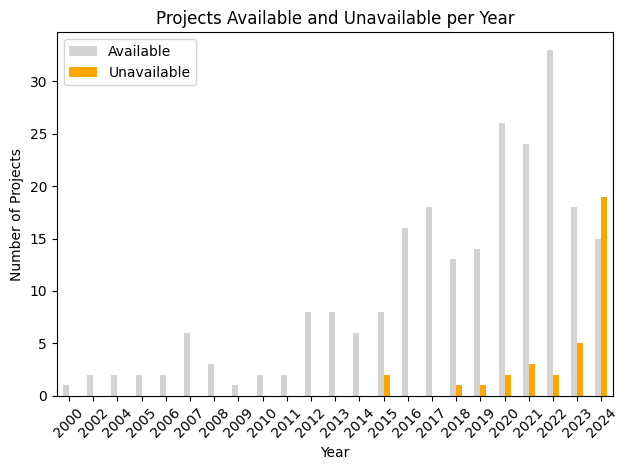

In [29]:
data = pd.read_csv(dataset1)

# Extract the year from the 'First_Seen' and 'Last_Seen' columns
data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')
data['Year_First_Seen'] = data[KEY_URL_PROGETTO_FIRST_SEEN].dt.year
data['Year_Last_Seen'] = data[KEY_URL_PROGETTO_LAST_SEEN].dt.year

# Calculate born projects
born_projects = data['Year_First_Seen'].value_counts().sort_index()

# Calculate dead projects
unavailable_projects = data[(data[KEY_URL_PROGETTO_LAST_SEEN].notna()) & (data[KEY_URL_PROGETTO_RISOLVE] == False)]['Year_Last_Seen'].value_counts().sort_index()

# Create a DataFrame for plotting
years = sorted(set(born_projects.index).union(set(unavailable_projects.index)))
available_counts = [born_projects.get(year, 0) for year in years]
unavailable_counts = [unavailable_projects.get(year, 0) for year in years]

df_years = pd.DataFrame({
  'Year': years,
  'Available': available_counts,
  'Unavailable': unavailable_counts
})

# Convert 'Year' column to integer for better readability on x-axis
df_years['Year'] = df_years['Year'].astype(int)

# Plot the bar chart
fig, ax = plt.subplots()
df_years.plot(kind='bar', x='Year', y=['Available', 'Unavailable'], ax=ax, color=['lightgrey', 'orange'])
ax.set_title('Projects Available and Unavailable per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

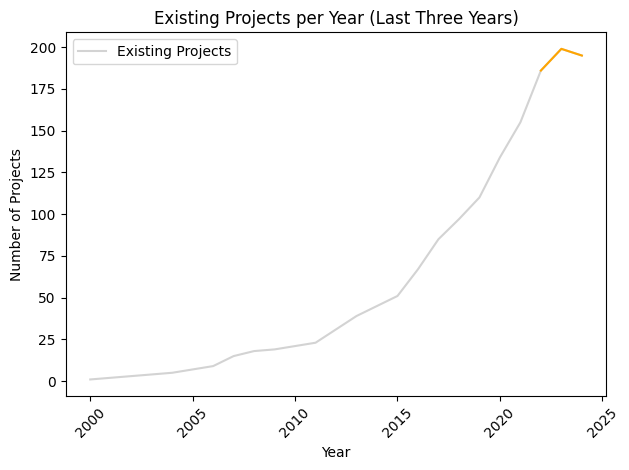

In [30]:
# Plot the line graph for existing projects per year
df_years['Existing'] = df_years.apply(lambda row: row['Available'] - row['Unavailable'], axis=1).cumsum()

fig, ax = plt.subplots()
ax.plot(df_years['Year'], df_years['Existing'], label='Existing Projects', color='lightgrey')

# Highlight the last three years
highlight_years = df_years.tail(3)
ax.plot(highlight_years['Year'], highlight_years['Existing'], color='orange')

ax.set_title('Existing Projects per Year (Last Three Years)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
ax.yaxis.get_major_locator().set_params(integer=True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [31]:
# Calculate the lifespan of each project

data = pd.read_csv(dataset2)

print(dead_projects.head())

dead_projects['Lifespan'] = (pd.to_datetime(dead_projects[KEY_URL_PROGETTO_LAST_SEEN]) - pd.to_datetime(dead_projects[KEY_URL_PROGETTO_FIRST_SEEN])).dt.days

valid_lifespans = dead_projects['Lifespan'].dropna()
mean_lifespan_days = valid_lifespans.mean()
mean_lifespan_years = mean_lifespan_days / 365

print(f"Mean lifespan of the projects that became unavailable: {mean_lifespan_years:.2f} years")

                                              Titolo  \
1  Toward an Audio Digital Library 2.0: SMASH, a ...   
2  The Challenges of Building Ex Libris Rosetta, ...   
3                                  Progetto TraMonti   
5                                    Alcide Digitale   
6                                              Atlas   

                                        URL progetto  URL progetto risolve?  \
1  https://avires.dimi.uniud.it/tmp/DL/Experiment...                  False   
2  https://exlibrisgroup.com/products/rosetta-dig...                  False   
3                   http://www.tramontivaldivara.it/                  False   
5            https://alcidedigitale.fbk.eu/platform/                  False   
6       https://dh-atlas.github.io/deliverables.html                  False   

  URL sito vetrina  URL sito vetrina risolve? URL Anticamera   \
1               NaN                     False             NaN   
2               NaN                     False             

In [32]:
import shutil

# Define the source and destination paths
source1 = dataset1
source2 = dataset2
destination1 = os.path.join(os.path.pardir, os.path.basename(dataset1))
destination2 = os.path.join(os.path.pardir, os.path.basename(dataset2))

# Copy the files
shutil.copy(source1, destination1)
shutil.copy(source2, destination2)

print(f"Copied {source1} to {destination1}")
print(f"Copied {source2} to {destination2}")

Copied /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/dataset_1.csv to ../dataset_1.csv
Copied /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/dataset_2.csv to ../dataset_2.csv
